In [5]:
import numpy as np
import mpmath as mp

In [7]:
def identify_phase_np(J1, J2, M, n_max=10, n_rg_steps=20, b=2, d=2, history_length=3, coeff_indices=(1, 0)):
    """
    Identify phase based on coefficient patterns with early stopping when convergence is detected.

    Args:
        J1, J2, M: Model parameters
        n_max: Maximum Fourier mode
        n_rg_steps: Maximum number of RG steps
        b: Length rescaling factor
        d: Dimension
        history_length: Number of past steps to track for convergence
        coeff_indices: Tuple (n,m) specifying which coefficient value to return

    Returns:
        Tuple (phase, coeff_value) where:
        - phase: String indicating the identified phase
        - coeff_value: Value of the chosen coefficient in final state
    """
    from renormalization_np import get_initial_coefficients as get_initial_coefficients_np
    from renormalization_np import rg_step as rg_step_np
    
    e = 1e-3  # Threshold for both phase identification and convergence

    # Initialize coefficient array
    lambda_nm = get_initial_coefficients_np(J1, J2, M, n_max)
    
    # Convert coeff_indices to array indices
    n_idx, m_idx = n_max + coeff_indices[0], n_max + coeff_indices[1]

    # Define coefficient keys to track
    coefficient_indices = [
        (n_max+1, n_max),    # coeff_10
        (n_max, n_max+1),    # coeff_01
        (n_max+1, n_max+1),  # coeff_11
        (n_max+2, n_max),    # coeff_20
        (n_max, n_max+2),    # coeff_02
        (n_max+2, n_max+2)   # coeff_22
    ]

    # Keep track of convergence status for each coefficient
    stable_iterations = {idx: 0 for idx in coefficient_indices}

    # Perform RG flow with convergence check
    prev_lambda_nm = None

    for i in range(n_rg_steps):
        lambda_nm = rg_step_np(lambda_nm, b, d)

        # Only start checking conditions after 6 iterations
        if i >= 5:  # This ensures the loop runs at least 6 times (i = 0, 1, 2, 3, 4, 5)
            # Check if the disordered phase is reached
            all_near_zero = True
            for n_idx_check, m_idx_check in coefficient_indices:
                coeff_value = lambda_nm[n_idx_check, m_idx_check].real
                if abs(coeff_value) >= e:
                    all_near_zero = False
                    break

            if all_near_zero:
                return "D_Phase", lambda_nm[n_idx, m_idx].real  # Early detection of disordered phase

            # Check for convergence if we have a previous state to compare with
            if prev_lambda_nm is not None:
                all_converged = True

                for n_idx_check, m_idx_check in coefficient_indices:
                    current_val = lambda_nm[n_idx_check, m_idx_check].real
                    prev_val = prev_lambda_nm[n_idx_check, m_idx_check].real

                    # Calculate difference between iterations
                    diff = abs(current_val - prev_val)

                    if diff < e:
                        stable_iterations[(n_idx_check, m_idx_check)] += 1
                    else:
                        stable_iterations[(n_idx_check, m_idx_check)] = 0
                        all_converged = False

                # Break if all coefficients have been stable for enough iterations
                if all_converged and all(count >= history_length-1 for count in stable_iterations.values()):
                    #print(f"All converged for J={J1}, M={M} at step {i}")
                    break

        # Store current state for next iteration
        prev_lambda_nm = lambda_nm.copy()

    #print(f"RG finalized at step {i}")

    # Extract final coefficients
    coeff_10 = lambda_nm[n_max+1, n_max].real
    coeff_01 = lambda_nm[n_max, n_max+1].real
    coeff_11 = lambda_nm[n_max+1, n_max+1].real
    coeff_20 = lambda_nm[n_max+2, n_max].real
    coeff_02 = lambda_nm[n_max, n_max+2].real
    coeff_22 = lambda_nm[n_max+2, n_max+2].real
    
    # Get the value of the requested coefficient
    coeff_value = lambda_nm[n_idx, m_idx].real

    # Phase conditions
    if (abs(coeff_10) < e and  # (1,0) = 0
        abs(coeff_01) < e and  # (0,1) = 0
        abs(coeff_11) < e and  # (1,1) = 0
        abs(coeff_20) < e and  # (2,0) = 0
        abs(coeff_02) < e and  # (0,2) = 0
        abs(coeff_22) < e):    # (2,2) = 0
        return "D_Phase", coeff_value  # Disordered
    elif (coeff_10 > e and  # (1,0) > 0
          coeff_01 > e and  # (0,1) > 0
          coeff_11 > e and  # (1,1) > 0
          coeff_20 > e and  # (2,0) > 0
          coeff_02 > e and  # (0,2) > 0
          coeff_22 > e):    # (2,2) > 0
        return "A_Phase", coeff_value
    elif (abs(coeff_10) < e and  # (1,0) = 0
          abs(coeff_01) < e and  # (0,1) = 0
          coeff_11 > e and       # (1,1) > 0
          coeff_20 > e and       # (2,0) > 0
          coeff_02 > e and       # (0,2) > 0
          coeff_22 > e):         # (2,2) > 0
        return "B_Phase", coeff_value
    elif (coeff_10 < -e and  # (1,0) < 0
          coeff_01 < -e and  # (0,1) < 0
          coeff_11 > e and   # (1,1) > 0
          coeff_20 > e and   # (2,0) > 0
          coeff_02 > e and   # (0,2) > 0
          coeff_22 > e):     # (2,2) > 0
        return "C_Phase", coeff_value
    elif (abs(coeff_10) < e and  # (1,0) = 0
          abs(coeff_01) < e and  # (0,1) = 0
          coeff_11 < -e and      # (1,1) < 0
          coeff_20 > e and       # (2,0) > 0
          coeff_02 > e and       # (0,2) > 0
          coeff_22 > e):         # (2,2) > 0
        return "E_Phase", coeff_value
    else:
        return "X_Phase", coeff_value


def identify_phase_mp(J1, J2, M, n_max=10, n_rg_steps=20, b=2, d=2, history_length=3, dps=30, coeff_indices=(1, 0)):
    """
    Identify phase based on coefficient patterns with early stopping when convergence is detected.
    Uses mpmath for high precision calculations.

    Args:
        J1, J2, M: Model parameters
        n_max: Maximum Fourier mode
        n_rg_steps: Maximum number of RG steps
        b: Length rescaling factor
        d: Dimension
        history_length: Number of past steps to track for convergence
        dps: Decimal places of precision for mpmath
        coeff_indices: Tuple (n,m) specifying which coefficient value to return

    Returns:
        Tuple (phase, coeff_value) where:
        - phase: String indicating the identified phase
        - coeff_value: Value of the chosen coefficient in final state
    """
    from renormalization_mp import get_initial_coefficients as get_initial_coefficients_mp
    from renormalization_mp import rg_step as rg_step_mp
    
    # Set mpmath decimal precision
    mp.dps = dps

    # Use mpmath precision for the threshold
    e = mp.mpf('1e-3')  # Threshold for both phase identification and convergence

    # Convert inputs to mpmath precision
    J1, J2, M = mp.mpf(str(J1)), mp.mpf(str(J2)), mp.mpf(str(M))
    
    # Convert coeff_indices to array indices
    n_idx, m_idx = n_max + coeff_indices[0], n_max + coeff_indices[1]

    # Get initial coefficients (already in mpmath format)
    lambda_nm = get_initial_coefficients_mp(J1, J2, M, n_max)

    # Define coefficient indices to track
    coefficient_indices = [
        (n_max+1, n_max),    # coeff_10
        (n_max, n_max+1),    # coeff_01
        (n_max+1, n_max+1),  # coeff_11
        (n_max+2, n_max),    # coeff_20
        (n_max, n_max+2),    # coeff_02
        (n_max+2, n_max+2)   # coeff_22
    ]
    
    # Keep track of convergence status for each coefficient
    stable_iterations = {idx: 0 for idx in coefficient_indices}
    
    # Perform RG flow with convergence check
    prev_lambda_nm = None
    
    for i in range(n_rg_steps):
        lambda_nm = rg_step_mp(lambda_nm, b, d)

        # Only start checking conditions after 6 iterations
        if i >= 5:  # This ensures the loop runs at least 6 times (i = 0, 1, 2, 3, 4, 5)
            # Check if the disordered phase is reached
            all_near_zero = True
            for n_idx_check, m_idx_check in coefficient_indices:
                coeff_value = lambda_nm[n_idx_check, m_idx_check].real
                if mp.fabs(coeff_value) >= e:
                    all_near_zero = False
                    break
                    
            if all_near_zero:
                return "D_Phase", lambda_nm[n_idx, m_idx].real  # Early detection of disordered phase
                
            # Check for convergence if we have a previous state to compare with
            if prev_lambda_nm is not None:
                all_converged = True
                
                for n_idx_check, m_idx_check in coefficient_indices:
                    current_val = lambda_nm[n_idx_check, m_idx_check].real
                    prev_val = prev_lambda_nm[n_idx_check, m_idx_check].real
                    
                    # Calculate difference between iterations using mpmath
                    diff = mp.fabs(current_val - prev_val)
                    
                    if diff < e:
                        stable_iterations[(n_idx_check, m_idx_check)] += 1
                    else:
                        stable_iterations[(n_idx_check, m_idx_check)] = 0
                        all_converged = False
                
                # Break if all coefficients have been stable for enough iterations
                min_stable_count = min(stable_iterations.values())
                if all_converged and min_stable_count >= history_length-1:
                    #print(f"All converged for J={J1}, M={M} at step {i}")
                    break
                
        # Store current state for next iteration
        prev_lambda_nm = lambda_nm.copy()

    #print(f"RG finalized at step {i}")
    
    # Extract normalized coefficients in mpmath format
    coeff_10 = lambda_nm[n_max+1, n_max].real
    coeff_01 = lambda_nm[n_max, n_max+1].real
    coeff_11 = lambda_nm[n_max+1, n_max+1].real
    coeff_20 = lambda_nm[n_max+2, n_max].real
    coeff_02 = lambda_nm[n_max, n_max+2].real
    coeff_22 = lambda_nm[n_max+2, n_max+2].real
    
    # Get the value of the requested coefficient
    coeff_value = lambda_nm[n_idx, m_idx].real

    # Phase conditions using mpmath's fabs
    if (mp.fabs(coeff_10) < e and  # (1,0) = 0
        mp.fabs(coeff_01) < e and  # (0,1) = 0
        mp.fabs(coeff_11) < e and  # (1,1) = 0
        mp.fabs(coeff_20) < e and  # (2,0) = 0
        mp.fabs(coeff_02) < e and  # (0,2) = 0
        mp.fabs(coeff_22) < e):    # (2,2) = 0
        return "D_Phase", coeff_value  # Disordered
    elif (coeff_10 > e and  # (1,0) > 0
          coeff_01 > e and  # (0,1) > 0
          coeff_11 > e and  # (1,1) > 0
          coeff_20 > e and  # (2,0) > 0
          coeff_02 > e and  # (0,2) > 0
          coeff_22 > e):    # (2,2) > 0
        return "A_Phase", coeff_value
    elif (mp.fabs(coeff_10) < e and  # (1,0) = 0
          mp.fabs(coeff_01) < e and  # (0,1) = 0
          coeff_11 > e and           # (1,1) > 0
          coeff_20 > e and           # (2,0) > 0
          coeff_02 > e and           # (0,2) > 0
          coeff_22 > e):             # (2,2) > 0
        return "B_Phase", coeff_value
    elif (coeff_10 < -e and  # (1,0) < 0
          coeff_01 < -e and  # (0,1) < 0
          coeff_11 > e and   # (1,1) > 0
          coeff_20 > e and   # (2,0) > 0
          coeff_02 > e and   # (0,2) > 0
          coeff_22 > e):     # (2,2) > 0
        return "C_Phase", coeff_value
    elif (mp.fabs(coeff_10) < e and  # (1,0) = 0
          mp.fabs(coeff_01) < e and  # (0,1) = 0
          coeff_11 < -e and          # (1,1) < 0
          coeff_20 > e and           # (2,0) > 0
          coeff_02 > e and           # (0,2) > 0
          coeff_22 > e):             # (2,2) > 0
        return "E_Phase", coeff_value
    else:
        return "X_Phase", coeff_value

In [9]:
def identify_phase_hybrid(J1, J2, M, coeff_indices=(1, 0), n_max_np=20, n_max_mp=10, 
                         n_rg_steps=20, b=2, d=2, history_length=3, dps=30, only_mp=False):
    """
    Hybrid approach to phase identification that uses numpy for speed
    and falls back to mpmath for precision when needed. Also returns the
    value of a specified coefficient.
    
    Args:
        J1, J2, M: Model parameters
        coeff_indices: Tuple (n,m) indicating which coefficient value to track
        n_max_np: Maximum Fourier mode for numpy calculations
        n_max_mp: Maximum Fourier mode for mpmath calculations
        n_rg_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        history_length: Number of past steps to track for convergence
        dps: Decimal places of precision for mpmath
        only_mp: Force using mpmath even for easy cases
        
    Returns:
        Tuple (phase, coeff_value) where:
        - phase: String indicating the identified phase
        - coeff_value: Value of the chosen coefficient in final state
    """
    from mpmath import mp
    
    if not only_mp:
        # First try with the faster numpy implementation
        phase, coeff_value = identify_phase_np(J1, J2, M, n_max_np, n_rg_steps, b, d, 
                                             history_length, coeff_indices)
        
        # If the numpy implementation returns "X_Phase" or fails to converge,
        # fall back to the more precise mpmath implementation
        if phase == "X_Phase":
            print(f"Falling back to mpmath for J1={J1}, J2={J2}, M={M}")
        else:
            return phase, coeff_value  # Return numpy result if it's not "X_Phase"
    
    # Convert parameters to mpmath precision
    J1_mp = mp.mpf(str(J1))
    J2_mp = mp.mpf(str(J2))
    M_mp = mp.mpf(str(M))
    
    # If only_mp is True or numpy returned "X_Phase", use mpmath
    # Use the mpmath implementation for increased precision
    phase, coeff_value = identify_phase_mp(J1_mp, J2_mp, M_mp, n_max_mp, n_rg_steps, b, d, 
                                         history_length, dps, coeff_indices)
    
    return phase, coeff_value

In [11]:
def generate_phase_diagram_joblib(J_values, M_values, coeff_indices=(1, 0), 
                                 n_max_np=20, n_max_mp=10, n_rg_steps=20, b=2, d=2, 
                                 history_length=3, dps=30, path=None, n_jobs=-1,
                                  only_mp=False, show_colorbars=False):
    """
    Generate phase diagram by scanning J, M parameter space using parallel processing with joblib.
    Also tracks values of a specified coefficient to visualize fixed line behavior.
    
    Args:
        J_values: Array of J values
        M_values: Array of M values
        coeff_indices: Tuple (n,m) specifying which coefficient value to track
        n_max: Maximum Fourier mode
        n_rg_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        history_length: Number of past steps to track for convergence
        path: Path to save the figure
        n_jobs: Number of parallel jobs (default -1 uses all cores)
        
    Returns:
        Dictionary with phase points and coefficient values
    """
    from joblib import Parallel, delayed
    
    # Function to process one point in parameter space
    def process_one_point(J, M):
        J1 = J2 = J
        phase, coeff_value = identify_phase_hybrid(J1, J2, M, coeff_indices,
                                                   n_max_np, n_max_mp,
                                                   n_rg_steps, b, d,
                                                   history_length, dps, only_mp)
        return J, M, phase, coeff_value
    
    # Create list of all parameter combinations
    total_points = len(J_values) * len(M_values)
    print(f"Starting calculation for {total_points} points with {n_jobs} jobs")
    
    # Process all points in parallel
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_one_point)(J, M) 
        for J in J_values 
        for M in M_values
    )
    
    # Initialize dictionaries to store points and coefficient values for each phase
    phase_dict = {
        "D_Phase": {"points": [], "coeffs": []},
        "A_Phase": {"points": [], "coeffs": []}, 
        "B_Phase": {"points": [], "coeffs": []},
        "C_Phase": {"points": [], "coeffs": []},
        "E_Phase": {"points": [], "coeffs": []},
        "X_Phase": {"points": [], "coeffs": []},
        "U_Phase": {"points": [], "coeffs": []}
    }
    
    # Organize results into phase groups
    for J, M, phase, coeff_value in results:
        if phase in phase_dict:
            phase_dict[phase]["points"].append([J, M])
            phase_dict[phase]["coeffs"].append(coeff_value)
        else:
            phase_dict["U_Phase"]["points"].append([J, M])
            phase_dict["U_Phase"]["coeffs"].append(coeff_value)
    
    # Convert lists to numpy arrays for easier handling
    for phase in phase_dict:
        if phase_dict[phase]["points"]:
            phase_dict[phase]["points"] = np.array(phase_dict[phase]["points"])
            phase_dict[phase]["coeffs"] = np.array(phase_dict[phase]["coeffs"])
    
    # Plot the results
    if path:
        plot_phase_diagram_with_coeffs(J_values, M_values, phase_dict, 
                                      coeff_indices, show_colorbars, path)
    
    return phase_dict

In [31]:
def plot_phase_diagram_with_coeffs(J_values, M_values, phase_dict, coeff_indices=(1, 0), 
                                  show_colorbars=True, path=None, marker_size=None):
    """
    Plot phase diagram with coefficient values represented by color gradients within each phase.
    
    Args:
        J_values: Array of J parameter values
        M_values: Array of M parameter values
        phase_dict: Dictionary of phase data including points and coefficient values
        coeff_indices: Tuple (n,m) indicating which coefficient is being visualized
        show_colorbars: Whether to show colorbars for coefficient values
        path: Optional path to save the figure
    
    Returns:
        Matplotlib figure
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize, LinearSegmentedColormap
    import matplotlib.cm as cm
    from matplotlib.gridspec import GridSpec
    
    # Define phases that will use color gradients
    gradient_phases = ["A_Phase", "B_Phase", "C_Phase", "E_Phase"]
    
    # Create figure with grid layout for main plot and colorbars
    if show_colorbars:
        fig = plt.figure(figsize=(8, 10), dpi=100)
        gs = GridSpec(len(gradient_phases) + 1, 1, height_ratios=[8] + [0.3] * len(gradient_phases))
        ax = fig.add_subplot(gs[0])
    else:
        fig = plt.figure(figsize=(8, 8), dpi=100)
        ax = fig.add_subplot(111)
    
    fig.set_facecolor("white")
    plt.rc(group="font", family="Arial", weight="bold", size=10)
    plt.rc(group="lines", linewidth=1)
    plt.rc(group="axes", linewidth=2)
    
    # Base colors for each phase
    base_colors = {
        "D_Phase": "white",
        "A_Phase": "blue",
        "B_Phase": "green",
        "C_Phase": "red",
        "E_Phase": "orange",
        "X_Phase": "black",
        "U_Phase": "yellow"
    }
    
    # Create custom colormaps from light to dense colors (not white)
    custom_colormaps = {
        "A_Phase": LinearSegmentedColormap.from_list("Blues_custom", ["#BBDEFB", "#0D47A1"]),  # Light blue to dark blue
        "B_Phase": LinearSegmentedColormap.from_list("Greens_custom", ["#C8E6C9", "#1B5E20"]),  # Light green to dark green
        "C_Phase": LinearSegmentedColormap.from_list("Reds_custom", ["#FFCDD2", "#B71C1C"]),  # Light red to dark red
        "E_Phase": LinearSegmentedColormap.from_list("Oranges_custom", ["#FFE0B2", "#E65100"])  # Light orange to dark orange
    }
    
    # Define legend handles for each phase
    legend_handles = []
    legend_labels = []
    
    # Store colorbar metadata for later creation
    colorbar_data = {}
    
    # Plot each phase
    for phase, data in phase_dict.items():
        points = data["points"]
        coeffs = data["coeffs"]
        
        if len(points) > 0:
            # Add a representative handle for the legend
            legend_handles.append(plt.Line2D([0], [0], marker='s', color='w', 
                                           markerfacecolor=base_colors[phase], markersize=10))
            legend_labels.append(phase)

            if marker_size:
                ms = marker_size
            # Only use color gradients for specified phases
            if phase in gradient_phases and len(points) > 1 and len(np.unique(coeffs)) > 1:
                # Create color array based on coefficient values
                norm = Normalize(vmin=np.min(coeffs), vmax=np.max(coeffs))
                colors = custom_colormaps[phase](norm(coeffs))

                # Store colorbar data for later
                if show_colorbars:
                    colorbar_data[phase] = {
                        'cmap': custom_colormaps[phase],
                        'norm': norm,
                        'vmin': np.min(coeffs),
                        'vmax': np.max(coeffs)
                    }
                
                # Scatter plot with color gradient
                ax.scatter(points[:, 1], points[:, 0], c=colors, 
                         marker='s', s=ms, edgecolor='none', alpha=1)
            else:
                # Use a solid color for other phases
                ax.scatter(points[:, 1], points[:, 0], c=base_colors[phase], 
                         marker='s', s=ms, edgecolor='none', alpha=1)
    
    # Add legend for phases
    #ax.legend(legend_handles, legend_labels, loc='upper right', title="Phases")
    
    # Set labels and styling for main plot
    ax.set_xlabel("Four-spin Interaction M", fontsize=14)
    ax.set_ylabel("Two-spin Interaction J", fontsize=14)
    ax.set_title(f"Phase Diagram with λ({coeff_indices[0]},{coeff_indices[1]}) Values", fontsize=16)
    ax.tick_params(axis="both", direction="in", width=2, length=4)
    
    # Set axis limits
    ax.set_xlim(min(M_values), max(M_values))
    ax.set_ylim(min(J_values), max(J_values))

    colormap_phase_names = ['F', r'F$_\sigma$', 'A', r'A$_\sigma$']
    # Add colorbars under the main plot
    if show_colorbars:
        # Only create colorbars for phases that actually exist in the diagram
        i = 0
        for phase in gradient_phases:
            if phase in colorbar_data:
                # Create a horizontal colorbar below the main plot
                cbar_ax = fig.add_subplot(gs[i+1])
                cb_data = colorbar_data[phase]
                sm = cm.ScalarMappable(cmap=cb_data['cmap'], norm=cb_data['norm'])
                sm.set_array([])
                
                # Make colorbar horizontal and thin without label
                cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
                
                # Add only a small phase indicator text at the beginning of the colorbar
                cbar_ax.text(0.01, 0.5, colormap_phase_names[i], #phase.split('_')[0], 
                            transform=cbar_ax.transAxes, 
                            verticalalignment='center',
                            fontsize=8, fontweight='bold')
                
                i += 1
    
    plt.tight_layout()
    
    if path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
    
    return fig

Starting calculation for 2704 points with 4 jobs


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   50.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 14.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 18.5min
[Parallel(

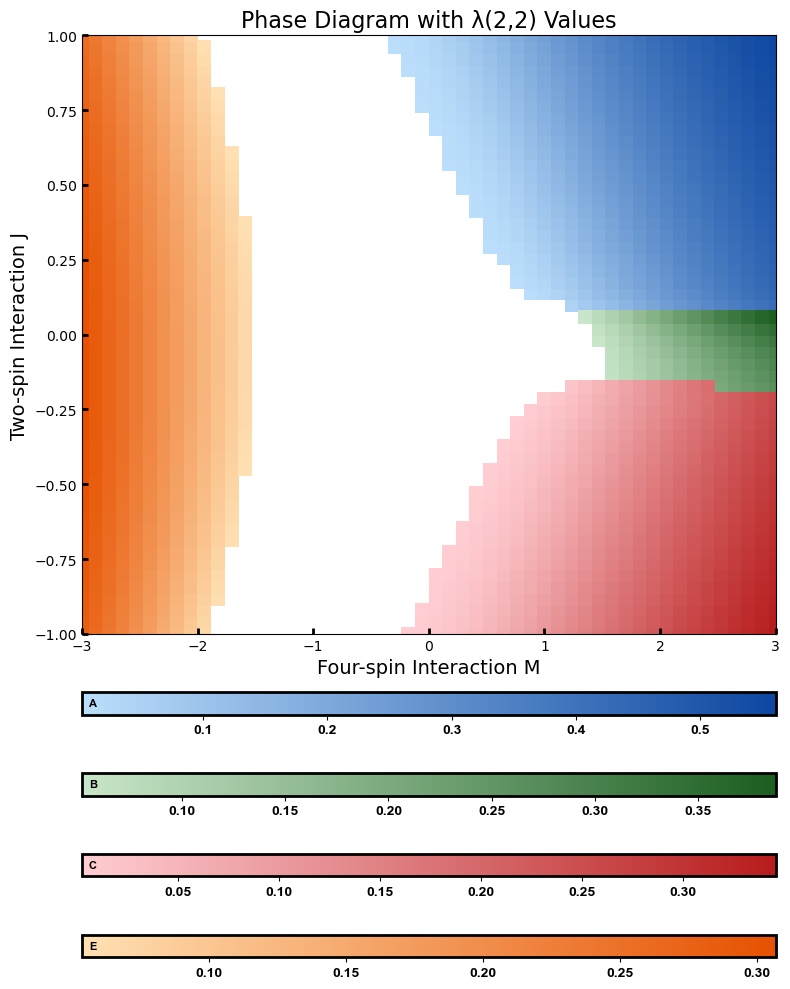

In [15]:
# Define parameter space
n_points = 52
J_values = np.linspace(-1, 1, num=n_points)  # Range of J values
M_values = np.linspace(-3.0, 3.0, num=n_points)  # Range of M values

# Choose which coefficient to track (n,m)
# (1,0) tends to show fixed line behavior and is common in the Berker paper
coeff_indices = (2, 2)

# Generate phase diagram with coefficient values
phase_dict = generate_phase_diagram_joblib(
    J_values=J_values,
    M_values=M_values,
    coeff_indices=coeff_indices,
    n_max_np=20,
    n_max_mp=10,
    n_rg_steps=55,
    b=3,
    d=2,
    history_length=5,
    dps=50,
    path=f"phase_diagram_with_coeff{coeff_indices}_{n_points}.png",
    n_jobs=4,
    only_mp=False,
    show_colorbars=True)

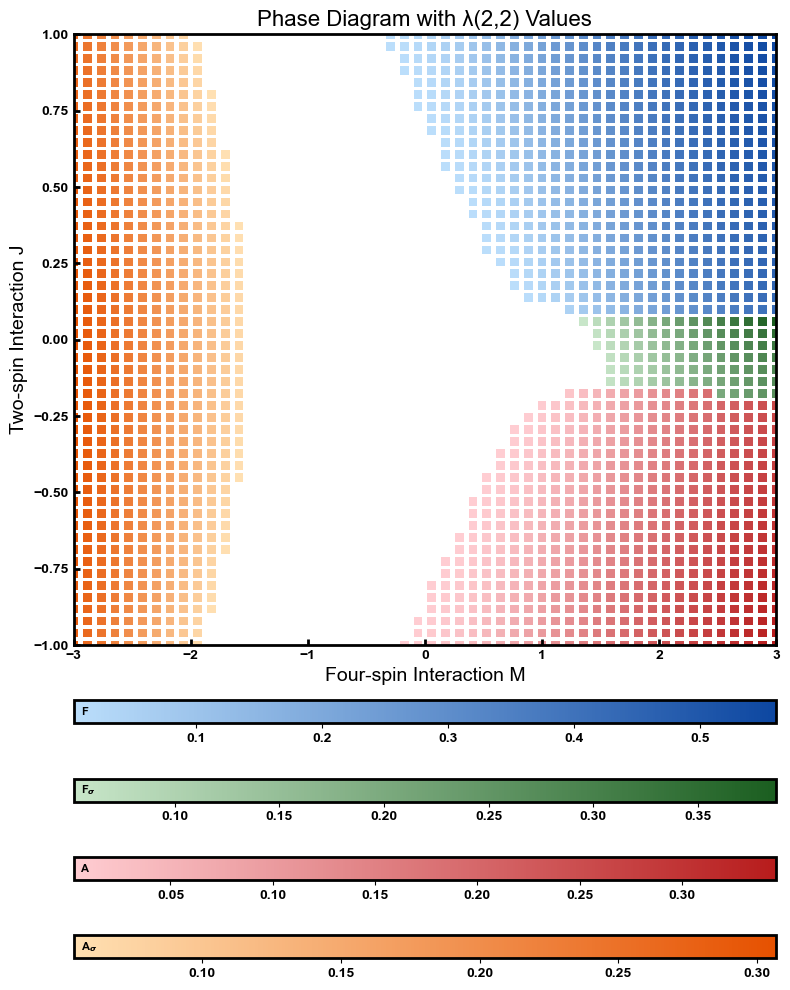

In [37]:
fig = plot_phase_diagram_with_coeffs(J_values, M_values, phase_dict,
                               coeff_indices, show_colorbars=True, path=None, marker_size=40)

In [116]:
[10] + [0.1]

[10, 0.1]

# Save phase diagram data

In [99]:
def save_phase_diagram_results(phase_dict, J_values, M_values, coeff_indices, filename):
    """
    Save phase diagram results to a pickle file for later use.
    
    Args:
        phase_dict: Dictionary containing phase data
        J_values: Array of J parameter values
        M_values: Array of M parameter values
        coeff_indices: Tuple (n,m) indicating which coefficient was tracked
        filename: Name of the file to save to
    """
    data = {
        'phase_dict': phase_dict,
        'J_values': J_values,
        'M_values': M_values,
        'coeff_indices': coeff_indices
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"Phase diagram data saved to {filename}")

In [101]:
save_phase_diagram_results(phase_dict, J_values, M_values, coeff_indices, f"phase_diagram_coeff_{n_points}.pkl")

Phase diagram data saved to phase_diagram_coeff_52.pkl


In [92]:
import pickle

result_data = {
        "phase_dict": phase_dict,
        "J_values": J_values,
        "M_values": M_values,
        "coeff_indices": coeff_indices,}
        #"n_max": n_max,
        #"n_rg_steps": n_rg_steps,
        #"b": b,
        #"d": d}

save_path = f"phase_diagram_coeff_{n_points}.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(result_data, f)

In [90]:
result_data['coeff_indices']

(2, 2)